# DataCleaning
We are going to do data cleaning on the MSR-VTT dataset in three steps: 
- Remove special characters.
- Correct spelling mistakes.
- Remove duplicated annotations.

In [1]:
import json
import zipfile as zf

## Load human annotations from compressed files

In [2]:
with zf.ZipFile("train_val_annotation.zip", "r") as myzip:
    train_val = json.load(myzip.open("train_val_videodatainfo.json"))
    
with zf.ZipFile("test_videodatainfo.json.zip", "r") as myzip:
    test = json.load(myzip.open("test_videodatainfo.json"))

In [3]:
train_val_sentences = train_val['sentences']
test_sentences = test['sentences']

train_sents = []
for s in train_val_sentences:
    if int(s['video_id'][5:]) < 6513:
        train_sents.append(s)

print('Sentence number in the training set:', len(train_sents))
        
val_sents = []
for s in train_val_sentences:
    idx = int(s['video_id'][5:])
    if 6513 <= idx < 7010:
        val_sents.append(s)
        
print('Sentence number in the validation set:', len(val_sents))

test_sents = test_sentences
print('Sentence in the testing set:', len(test_sents))

Sentence number in the training set: 130260
Sentence number in the validation set: 9940
Sentence in the testing set: 59800


In [4]:
train_word_cnt = 0

for s in train_sents:
    s = s['caption']
    train_word_cnt += len(s.strip().split())

print('Word count in the training set:', train_word_cnt)

val_word_cnt = 0
for s in val_sents:
    s = s['caption']
    val_word_cnt += len(s.strip().split())
print('Word count in the validation set:', val_word_cnt)

test_word_cnt = 0
for s in test_sents:
    s = s['caption']
    test_word_cnt += len(s.strip().split())
    
print('Word count in the testing set:', test_word_cnt)

Word count in the training set: 1207727
Word count in the validation set: 91689
Word count in the testing set: 557105


In [5]:
def get_word_set(dataset):
    word_set = set()
    for s in dataset:
        caption = s['caption']
        words = caption.strip().split()
        word_set |= set(words)
    return word_set

train_word_set = get_word_set(train_sents)
val_word_set = get_word_set(val_sents)
test_word_set = get_word_set(test_sents)

print('Vocabulary size in the training set: {}'.format(len(train_word_set)))
print('Vocabulary size in the validation set: {}'.format(len(val_word_set)))
print('Vocabulary size in the testing set: {}'.format(len(test_word_set)))

Vocabulary size in the training set: 23666
Vocabulary size in the validation set: 5993
Vocabulary size in the testing set: 16001


Text(0.5, 1.0, 'Sentence length distribution')

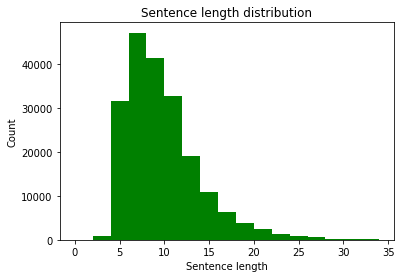

In [6]:
sent_len_list = []
for s in train_sents:
    sent = s['caption']
    sent_len_list.append(len(sent.strip().split()))
    
for s in val_sents:
    sent = s['caption']
    sent_len_list.append(len(sent.strip().split()))
    
for s in test_sents:
    sent = s['caption']
    sent_len_list.append(len(sent.strip().split()))
    

import matplotlib.pyplot as plt

plt.hist(sent_len_list, list(range(0, 36, 2)), facecolor='g')
plt.xlabel('Sentence length')
plt.ylabel('Count')
plt.title('Sentence length distribution')

### Obtain the mapping from video to captions

In [7]:
from collections import defaultdict

video2caption = defaultdict(lambda:[])
train_set, val_set, test_set = defaultdict(lambda:[]), defaultdict(lambda:[]), defaultdict(lambda:[])

for s in train_sents:
    vidx = int(s['video_id'][5:])
    video2caption[vidx].append(s)
    train_set[vidx].append(s)
    
for s in val_sents:
    vidx = int(s['video_id'][5:])
    video2caption[vidx].append(s)
    val_set[vidx].append(s)
    
for s in test_sents:
    vidx = int(s['video_id'][5:])
    video2caption[vidx].append(s)
    test_set[vidx].append(s)

print('Videos in total: {}, videos in the training set: {}, videos in the validation set: {}, videos in the testing set: {}.'.
      format(len(video2caption), len(train_set), len(val_set), len(test_set)))

Videos in total: 10000, videos in the training set: 6513, videos in the validation set: 497, videos in the testing set: 2990.


## Remove special characters

Firstly, we will show all the characters existing in the dataset. And then, we try to remove the peculiar ones in them.

In [8]:
def get_charset(video2caption):
    charset = set()

    for vid in video2caption:
        captions = video2caption[vid]
        for caption in captions:
            words = caption['caption'].strip().split()
            for word in words:
                charset |= set(list(word))
    return charset

charset = get_charset(video2caption)
print('Characters: {}'.format(sorted(list(charset))))
print('Character count: {}'.format(len(charset)))

Characters: ['#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '>', '@', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', 'é', 'в', '’']
Character count: 60


### Remove 1
"#", "*", "+", ".", ":", "=", ">", "\\" are removed from the sentences.

In [9]:
import copy

origin_chars = ["#", "*", ".", ":", "+", "=", ">", "\\"]

def show_examples(data_set, chars):
    for vidx, sents in data_set.items():
        for sent in sents:
            for c in chars:
                if c in sent['caption']:
                    print("Example for '{}': {}".format(c, sent['caption']))
                    chars.remove(c)
                    break
            
            
chars = copy.deepcopy(origin_chars)
print('Training set examples.')
show_examples(train_set, chars)
        
print('\n\nValidation set examples.')
chars = copy.deepcopy(origin_chars)
show_examples(val_set, chars)
        
        
print('\n\nTesting set examples.')
chars = copy.deepcopy(origin_chars)
show_examples(test_set, chars)

Training set examples.
Example for '=': an audience watching a group of performet=rs
Example for ':': scenes from the movie avengers: age of ultron
Example for '\': an individual describing\ what he is seeing on his screen
Example for '#': reactions to sports vine #20
Example for '+': ted ideas worth spreading one of 1000+ ted talks
Example for '*': a vehicle on a city road passes a blue car speeding down the road*


Validation set examples.
Example for '#': com clip from a list and #8 on that list is nicholas brody from homeland (2011) followed by a spooky scary pirate face
Example for ':':  annie leblanc  had a huge victory yesterday in the 1660m race with a final time of 4:16


Testing set examples.
Example for ':': three children battle on the voice kids: philippines
Example for '#': entry #10 from a top list showing a play from an nfl game
Example for '>': sports highlights are shown on tv>
Example for '.': a woman is dacning in the clip.
Example for '=': an animation of a black a

In [10]:
# The set of sentences/videos that are corrected in this step.
sent_set = set()
vid_set = set()

new_video2caption_step1 = defaultdict(lambda: [])

for vidx, sents in video2caption.items():
    new_sents = []
    for sidx, sent in enumerate(sents):
        new_sent = sent['caption'].replace("#", "")
        new_sent = new_sent.replace("*", "")
        new_sent = new_sent.replace("+", "")
        new_sent = new_sent.replace(".", "")
        new_sent = new_sent.replace(":", "")
        new_sent = new_sent.replace("=", "")
        new_sent = new_sent.replace(">", "")
        new_sent = new_sent.replace("\\", "")
        sent2 = {'video_id': sent['video_id'], 'sen_id': sent['sen_id'], 'caption': new_sent}
        new_sents.append(sent2)
        if sent['caption'] != new_sent:
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
    new_video2caption_step1[vidx] = new_sents

In [11]:
with open("step1_1_videodatainfo_detail.json", "w") as fo:
    json.dump(new_video2caption_step1, fo)

"\[\]"s and "()"s will be removed.

In [12]:
import re

for vidx, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = re.sub(r"\[[\w \d/-]+\]", "", sent['caption'])
        if new_sent != sent['caption']:
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            new_sent = " ".join(new_sent.split())
            new_video2caption_step1[vidx][sidx]['caption'] = new_sent
            
            
for vidx, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = re.sub(r"\([\w \d/-]+\)", "", sent['caption'])
        if new_sent != sent['caption']:
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            new_sent = " ".join(new_sent.split())
            new_video2caption_step1[vidx][sidx]['caption'] = new_sent
            

### Examples
Here is some examples for '\[' or '\]' or '(' that appear in the sentences alone.

In [13]:
for vidx, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        if '[' in sent['caption'] or ']' in sent['caption'] or '(' in sent['caption'] or ')' in sent['caption']:
            print(sent['caption'])

two kids are having fun in water]
a video of agriculture production]
 asc (academy-award winning cinematographer speaking about an film
man and women getting physical or intimate cuts to a scene of shampoo or lotion dripping out of the bottle (implying i am guessing climax
a scene from the movie girls just wanna have fun featuring a male dancer supporting his female partner in a one-armed lift on a dancing tv show as another couple (including actress
a man p[laying golf 
a man with hair is sitting in a p[lace
the crazy train ( reed streets  music  with soft ball players in white bottoms and blue tops 


"\["s, "\]"s, "\("s,  that are single, will be removed.

In [14]:
import re
cnt = 0
for vidx, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = sent['caption'].replace("[", "")
        new_sent = new_sent.replace("]", "")
        new_sent = new_sent.replace("(", "")
        if new_video2caption_step1[vidx][sidx]['caption'] != new_sent:
            new_video2caption_step1[vidx][sidx]['caption'] = new_sent
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            cnt += 1

cnt

8

In [15]:
with open("step1_2_videodatainfo_detail.json", "w") as fo:
    json.dump(new_video2caption_step1, fo)

"-", "|", "'", "\`", "\@", "\_", "\/" are replace by a space " ".

In [16]:
origin_chars = ["-", "|", "‘", "’", "@", "_", "/"]

chars = copy.deepcopy(origin_chars)

show_examples(train_set, chars)

Example for '-': three contestants and host prepare for a low-budget game show
Example for '/': someone working on a drawing in ms paint/
Example for '@': an advertisement is displayed for the @mattsteffanina twitter profile featuring ariana grande jason derulo and tyga
Example for '_': drums are played in the background music video is shown of a small white car in a rural setting the title is travel vlog_1 wicklow
Example for '’': visions of apples are portrayed as a woman’s voice comments on the benefits of apples


In [17]:
cnt = 0

for vidx, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = sent['caption'].replace("-", " ")
        new_sent = new_sent.replace("|", " ")
        new_sent = new_sent.replace("‘", " ")
        new_sent = new_sent.replace("’", " ")
        new_sent = new_sent.replace("@", " ")
        new_sent = new_sent.replace("_", " ")
        new_sent = new_sent.replace("/", " ")
        new_sent = " ".join(new_sent.split())
        if new_video2caption_step1[vidx][sidx]['caption'] != new_sent:
            new_video2caption_step1[vidx][sidx]['caption'] = new_sent
            cnt += 1
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])

cnt

6971

In [18]:
with open("step1_3_videodatainfo_detail.json", "w") as fo:
    json.dump(new_video2caption_step1, fo)

'é', 'в' are replaced by "e" and "b".

In [19]:
for vidx, sents  in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = sent['caption'].replace('é', 'e')
        new_sent = new_sent.replace('в', 'b')
        if new_sent != new_video2caption_step1[vidx][sidx]['caption'] != new_sent:
            cnt += 1
            new_video2caption_step1[vidx][sidx]['caption'] = new_sent
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            
cnt

6978

' & 's are substituted by 'and'. And '&'s that are part of words, are not replaced.

In [20]:
for vid, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        if ' & ' in sent['caption']:
            new_sent = sent['caption'].replace(' & ', ' and ')
            new_sent = ' '.join(new_sent.split())
            new_video2caption_step1[vid][sidx]['caption'] = new_sent
            cnt += 1
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            
cnt

7050

'\`s' will be replaced by ' s', otherwise it will be removed.

In [21]:
for vid, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        new_sent = sent['caption'].replace('`s', ' s')
        new_sent = new_sent.replace('`', '')
        new_sent = " ".join(new_sent.split())
        if new_video2caption_step1[vid][sidx]['caption'] != new_sent:
            new_video2caption_step1[vid][sidx]['caption'] = new_sent
            cnt += 1
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            
cnt

7058

In [22]:
with open("step1_videodatainfo_detail.json", "w") as fo:
    json.dump(new_video2caption_step1, fo)
    
cnt = 0
for vidx, sents in video2caption.items():
    for sidx in range(len(sents)):
        if video2caption[vidx][sidx]['caption'] != new_video2caption_step1[vidx][sidx]['caption']:
            cnt += 1
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            
print('{} sentences have been modified in this section.'.format(cnt))

new_charset = get_charset(new_video2caption_step1)
print('new character set: {}, cnt: {}'.format(new_charset, len(new_charset)))
print(f'The number of sentences changed: {len(sent_set)}, videos changed {len(vid_set)}')

7247 sentences have been modified in this section.
new character set: {'e', 'd', 'v', 'w', 'n', 'l', 'q', 't', '%', '0', '5', 'g', 'a', '3', '6', 'p', '4', 'z', 'x', '$', '9', 's', 'u', '2', 'b', 'm', 'y', 'f', 'c', '7', 'o', 'r', '8', '&', 'k', 'j', 'h', 'i', '1'}, cnt: 39
The number of sentences changed: 7248, videos changed 4190


## Correct spelling mistakes
In this section, we are going to correct some spelling mistakes detected by `HunSpell`.

Firstly, we substitute British English spellings with American English ones.

In [23]:
with open('english_america.txt', 'r') as fo:
    lines = fo.readlines()
english2america = {}
for line in lines:
    word1, word2 = line.strip().split(' -> ')
    english2america[word1] = word2
    
cnt = 0
print_cnt = 0
# set of sentences or videos that have been changed.
sent_set = set()
vid_set = set()

new_video2caption_step2 = defaultdict(lambda: [])

for vid, sents in new_video2caption_step1.items():
    for sidx, sent in enumerate(sents):
        words = sent['caption'].strip().split()
        for widx, word in enumerate(words):
            if word in english2america:
                words[widx] = english2america[word]
                cnt += 1
        new_sent = " ".join(words)
        if new_video2caption_step1[vid][sidx]['caption'] != new_sent:
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            if print_cnt < 10:
                print_cnt += 1
                print("example {}: {} -> {}".format(print_cnt, new_video2caption_step1[vid][sidx]['caption'], new_sent))
        sent['caption'] = new_sent
        new_video2caption_step2[vid].append(sent)
        
print('Replace count: {}.'.format(cnt))

example 1: a man gets hit in the face with a chair during a wwf wrestling match -> a man gets hit in the face with a chair during a wwe wrestling match
example 2: a man is hitting another man with chair in wwf -> a man is hitting another man with chair in wwe
example 3: this is a wwf wrestling match -> this is a wwe wrestling match
example 4: a man gets hit in the face with a chair during a wwf wrestling match -> a man gets hit in the face with a chair during a wwe wrestling match
example 5: a woman is modelling for a piece of clothing -> a woman is modeling for a piece of clothing
example 6: a woman is modelling for a piece of clothing -> a woman is modeling for a piece of clothing
example 7: there is a man who met another man in this video and he is also travelling in a car -> there is a man who met another man in this video and he is also traveling in a car
example 8: a female character fights freddy kreuger -> a female character fights freddy krueger
example 9: mortal kombat fatali

Secondly, we split words that are composed of two individual words.

In [24]:
with open('split.txt', 'r') as fo:
    lines = fo.readlines()
split_dict = {}
for line in lines:
    word1, word2 = line.strip().split(' -> ')
    split_dict[word1] = word2
    
print_cnt = 0
for vidx, sents in new_video2caption_step2.items():
    for sidx, sent in enumerate(sents):
        words = sent['caption'].strip().split()
        for widx, word in enumerate(words):
            if word in split_dict:
                words[widx] = split_dict[word]
                cnt += 1
        new_sent = " ".join(words)
        
        if new_video2caption_step2[vidx][sidx]['caption'] != new_sent:
            sent_set.add(sent['sen_id'])
            vid_set.add(sent['video_id'])
            if print_cnt < 10:
                print_cnt += 1
                print('sample {}: {} -> {}'.format(print_cnt, new_video2caption_step2[vidx][sidx]['caption'], new_sent))
        sent['caption'] = new_sent            
        new_video2caption_step2[vidx][sidx] = sent
        
print('Replace count: {}.'.format(cnt))

sample 1: a clip from dragonball z -> a clip from dragon ball z
sample 2: a dragonball z scene where a bold man yells kamehame ya -> a dragon ball z scene where a bold man yells kamehame ya
sample 3: video game characters are passing by eachother -> video game characters are passing by each other
sample 4: a third person videogame character walking into a poke center in the pokemon game -> a third person video game character walking into a poke center in the pokemon game
sample 5: a woman talking on talkshow -> a woman talking on talk show
sample 6: gameplay of a videogame is shown -> gameplay of a video game is shown
sample 7: pokemon character walking in the pokecenter -> pokemon character walking in the pokemon center
sample 8: someone is playing pokemon on a gameboy -> someone is playing pokemon on a game boy
sample 9: someone playing pokemon on gameboy -> someone playing pokemon on game boy
sample 10: a third person videogame character walking into a poke center in the pokemon gam

Thirdly, we correct words using hunspell.

In [25]:
import hunspell
import multiprocessing as mp


ParallelNum = 32

spellchecker = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

with open('dictionary.txt', 'r') as fo:
    words = fo.readlines()
    words = [w.strip() for w in words]

for w in words:
    spellchecker.add(w)
    
def correct_words(words):
    ret_words = []
    count = 0
    for word in words:
        if spellchecker.spell(word):
            ret_words.append(word)
        else:
            suggestions = spellchecker.suggest(word)
            if len(suggestions) > 0:
                ret_words.append(suggestions[0])
                count += 1
            else:
                ret_words.append(word)
    return ret_words, count

def correct_videos(video2caption):
    cnt = 0
    correct_sent_set = set()
    correct_vid_set = set()
    for vidx, captions in video2caption.items():
        for sidx, caption in enumerate(captions):
            words, c = correct_words(caption['caption'].strip().split())
            cnt += c
            video2caption[vidx][sidx]['caption'] = " ".join(words).lower()
            if c > 0:
                correct_sent_set.add(caption['sen_id'])
                correct_vid_set.add(caption['video_id'])
    return video2caption, cnt, correct_sent_set, correct_vid_set


with mp.Pool(ParallelNum) as pool:
    video_list = [{} for _ in range(ParallelNum)]
    for vidx, captions in new_video2caption_step2.items():
        video_list[vidx%ParallelNum][vidx] = captions
    
    results = []
    for idx in range(ParallelNum):
        results += [pool.apply_async(correct_videos, [video_list[idx]])]
    results = [r.get() for r in results]
    
for r in results:
    videos = r[0]
    cnt += r[1]
    sent_set |= r[2]
    vid_set |= r[3]
    for key in videos:
        new_video2caption_step2[key] = videos[key]
        
print('{} words have been corrected.'.format(cnt))
print(f'{len(sent_set)} sentences and {len(vid_set)} videos have been corrected.')

ModuleNotFoundError: No module named 'hunspell'

Sample ten videos randomly and check them.

In [ ]:
import random

for _ in range(10):
    idx = random.randint(0, 10000)
    print(new_video2caption_step2[idx][0]['caption'], new_video2caption_step2[idx][1]['caption'], sep='\n')

In [ ]:
with open("step2_videodatainfo_detail.json", "w") as fo:
    json.dump(new_video2caption_step2, fo)

## Remove duplicated annotations
Now, we are going to remove duplicated annotations.

Here is the function used to compute sentence similarity with edit distance as a metric.

In [ ]:
from nltk.metrics.distance import edit_distance
import numpy as np

ED_THRESHOLD = 0

def sentence_similarity(sent1, sent2):
    words1 = sent1.strip().split()
    words2 = sent2.strip().split()
    
    dp_mat = np.zeros(shape=(len(words1)+1, len(words2)+1), dtype=int)
    for idx1 in range(len(words1)):
        for idx2 in range(len(words2)):
            w_dist = edit_distance(words1[idx1], words2[idx2])
            dist0 = dp_mat[idx1, idx2] + (1 if w_dist<=ED_THRESHOLD else 0)
            dp_mat[idx1+1, idx2+1] = max(dist0, dp_mat[idx1, idx2+1], dp_mat[idx1+1, idx2])
    lcs = dp_mat[len(words1), len(words2)]
    similarity = 0.5 * (lcs / len(words1) + lcs / len(words2))
    
    return similarity, lcs

An example for sentence similarity.

In [ ]:
sent1 = "a woman is singing on a music video"
sent2 = "a young woman is singing in a music video"

sentence_similarity(sent1, sent2)

In [ ]:
Threshold = 0.85
cnt = 0
# The number of videos that have been deduplicated.
vids_cnt = 0

def remove_duplicate_captions(video2caption):
    cnt = 0
    vid_cnt = 0
    for vidx, captions in video2caption.items():
        similar_captions = defaultdict(list)
        inserted = np.zeros(shape=(len(captions),), dtype=int)
        for cidx1 in range(len(captions)):
            if inserted[cidx1]:
                continue
            similar_captions[cidx1].append(captions[cidx1])
            inserted[cidx1] = 1
            for cidx2 in range(cidx1 + 1, len(captions)):
                if inserted[cidx2]:
                    continue

                simil, _ = sentence_similarity(captions[cidx1]['caption'], captions[cidx2]['caption'])
                if simil >= Threshold:
                    similar_captions[cidx1].append(captions[cidx2])
                    inserted[cidx2] = 1
        
        new_captions = [sorted(cs, key=lambda x: len(x['caption']), reverse=True)[0] for _, cs in similar_captions.items()]
        cnt += len(new_captions)
        if len(video2caption[vidx]) > len(new_captions):
            vid_cnt += 1
        video2caption[vidx] = new_captions

    return video2caption, cnt, vid_cnt

videos_list = [{} for _ in range(ParallelNum)]
for vidx, captions in new_video2caption_step2.items():
    videos_list[vidx%ParallelNum][vidx] = captions

with mp.Pool(ParallelNum) as pool:
    rlist = []
    for vl in videos_list:
        rlist.append(pool.apply_async(remove_duplicate_captions, [vl]))
    rlist = [r.get() for r in rlist]

new_video2caption_step3 = defaultdict(list)

for v, c, vid_cnt in rlist:
    cnt += c
    vids_cnt += vid_cnt
    new_video2caption_step3.update(v)
    
    
print('{} captions remain.'.format(cnt))
print(f'{vids_cnt} videos that have been deduplicated.')

In [ ]:
with open('step3_videodatainfo_prob_85_detail.json', 'w') as fo:
    json.dump(new_video2caption_step3, fo)

In [ ]:
train_cnt, val_cnt, test_cnt = 0, 0, 0

for vidx, sents in new_video2caption_step3.items():
    if vidx < 6513:
        train_cnt += len(sents)
    elif vidx < 7010:
        val_cnt += len(sents)
    else:
        test_cnt += len(sents)
        
print('Train count: {}, validation count: {}, test count: {}.'.format(train_cnt, val_cnt, test_cnt))

In [ ]:
min_cnt, max_cnt = 1000, 0

for vidx, sents in new_video2caption_step3.items():
    min_cnt = min(min_cnt, len(sents))
    max_cnt = max(max_cnt, len(sents))

print('minimum caption count is {}, maximum caption count is {}.'.format(min_cnt, max_cnt))

## Simplify redundant sentences

In [ ]:
import numpy as np


avg_sen_len_list = []


for key, val in new_video2caption_step3.items():
    for sen in val:
        avg_sen_len_list += [len(sen['caption'].strip().split())]
    
        
print(np.mean(avg_sen_len_list), np.median(avg_sen_len_list), np.std(avg_sen_len_list))
avg_len, std_len = np.mean(avg_sen_len_list), np.std(avg_sen_len_list)
cnt2, cnt3, cnt4 = 0, 0, 0

for length in avg_sen_len_list:
    if length > avg_len + 2 * std_len:
        cnt2 += 1
        
    if length > avg_len + 3 * std_len:
        cnt3 += 1
        
    if length > avg_len + 4 * std_len:
        cnt4 += 1
        
print(cnt2, cnt3, cnt4)

In [ ]:
multiple_sentences = []

for vid, sentences in new_video2caption_step3.items():
    if vid < 7010:
        continue

    for sid, sentence in enumerate(sentences):
        words = sentence['caption'].strip().split()
        if len(words) > avg_len + 3 * std_len:
            multiple_sentences.append("{}, {}, {}".format(vid, sid, sentence['caption']))
            
print(len(multiple_sentences))
multiple_sentences[:10]

In [ ]:
with open("multiple_sentences.txt", "w") as fo:
    for line in multiple_sentences:
        fo.write(line + "\n")

In [ ]:
with open("multiple_sentences[700].txt", "r") as fo:
    cleaned_sentences = fo.readlines()
    cleaned_sentences = [line.strip().lower() for line in cleaned_sentences]
    
cleaned_sentences[:10]

In [ ]:
list(new_video2caption_step3.items())[0]

In [ ]:
import copy

new_video2caption_step4 = copy.deepcopy(new_video2caption_step3)

sent_set = set()
vid_set = set()
for line in cleaned_sentences:
    vid, sid, sent = line.strip().split(", ")
    vid, sid = int(vid), int(sid)
    sent = sent.strip()
    if new_video2caption_step4[vid][sid]['caption'] != sent:
        print('old: {}, new: {}'.format(new_video2caption_step4[vid][sid]['caption'], sent))
        new_video2caption_step4[vid][sid]['caption'] = sent
        sent_set.add(sid + vid * 100)
        vid_set.add(vid)
        

for vid, sents in new_video2caption_step4.items():
    if vid >= 7010:
        continue
    for sidx, s in enumerate(sents):
        caption = " ".join(s['caption'].strip().split()[:18])
        if caption != s['caption']:
            sent_set.add(vid * 100 + sidx)
            vid_set.add(vid)
        s['caption'] = caption
    new_video2caption_step4[vid] = sents


print(f"modified sentences: {len(sent_set)}, videos: {len(vid_set)}")


In [ ]:
with open('step4_videodatainfo_detailed.json', 'w') as fo:
    json.dump(new_video2caption_step4, fo)

In [ ]:
new_video2caption_step4[0][0]